# Confidence and Unlearning in Decision-Making in Turbulent Environments

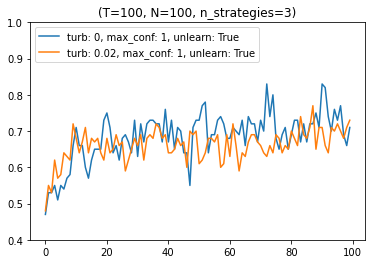

In [8]:
from simmeth.simulation.simulation import Simulation

env_scenarios = [
    {
        'prefix': "env_1_",
        'turb': 0,
        'max_confidence': 1,
        'unlearn': True
    },
    {
        'prefix': "env_2_",
        'turb': 0.02,
        'max_confidence': 1,
        'unlearn': True
    }
]
sim = Simulation(scenarios=env_scenarios, n_strategies=3, t=100, n=100)
sim.run()
sim.plot_scenarios()

## Concept

### General Assumptions

An agent faces $ m \in \mathbb{N} $ different *alternatives* $ A_i $. Each alternative $ A_i $ contains a temporarily fixed success probability $ p_i \in [0,1] $. The agent forms assumptions about the true value of each $ p_i $ by *beliefs* that change over time. The agent sequentially needs to select one of the $ m $ alternatives a total of $ T \in \mathbb{N} $ times.

### Belief

For each belief $ B_i, i \in \{1, ..., m\} $ we model the agent's assumption of the true success probability value $p_i$ at time $ t \in \{1, ..., T\} $ by a $Beta(p_
{it},q_{it})$ distribution, i.e.

$$ f_{it}(x) = \frac 1 {B(p_{it},q_{it})} x^{p_{it}-1} (1-x)^{q_{it}-1},\ \ p_{it}, q_{it} \in \mathbb{N}, \forall  i \in \{1, ..., m\}, \forall  t \in \{1, ..., T\} $$

Note that from the perspective of the agent, the success probability is a random variable distributed according to the author's belief distribution $ f_
{it} $ at time step $ t $. From the environment's perspective the success probability is a fixed parameter, however, that might change due to turbulence.

### Confidence

We model the confidence $ c_{it} $ of belief $ B_i $ at time $ t $ by one minus the standard deviation $ \sigma_{it} $ of the respective belief distribution $ f_
{it} $.

$$ c_{it} := 1 - \sigma_{it} = 1 - \sqrt {\frac { p_{it}q_{it} } { (p_{it}+q_{it}+1) (p_{it}+q_{it})^2 } } $$

Therefore, higher values of $ c_{it} $ refer to a "sharper" respective belief distribution $ f_{it} $ and smaller range of values an agent actively considers.

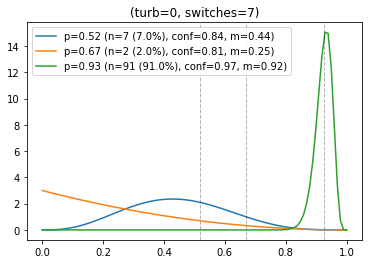

In [9]:
# Example plot of three belief distributions
sim.envs_history[0].plot()

## Exploratory Data Analysis

Each row in the generated dataframe from the simulation contains a single strategy (identified by `strategy_id`) at a given time step `t` for a specific environment `env_name`.

- `env_name` - Environment name to differentiate between environments (number of environments is determined by number of simulations $ N $ times sequence length $ T $)
- `strategy_id` - Identifier for respective strategy
- `t` - Time step, $t \in \{1, ..., T\}$
- `p` - True (unknown) success probability of underlying alternative, $p_i \in [0, 1]$
- `conf` - Confidence $ c_{it} $ of underlying belief at time step *t*
- `mean` - Mean of underlying belief at time step *t*
- `selected` - Indicator whether alternative was selected at time step *t*
- `alt_n` - Count for how many times this alternative has been picked in the past
- `switch_times` - How many times did the agent switch strategies? His initial choice at `t=1` is considered as a switch.
- `best` - Is the agent's choice the best possible alternative, i.e. the alternative with the highest success probability `p`? (only set when `selected`=1)
- `best_guess` - Is the agent's choice her best possible guess, i.e. the alternative with the highest mean belief? (only set when `selected`=1) If multiple beliefs share max means they are all considered as best guesses.

In [10]:
df = sim.get_env_strategy_dfs()

In [11]:
df.head(10)

,env_name,strategy_id,t,p,conf,mean,selected,alt_n,switch_times,best,best_guess
0,env_1_0,0,1,0.517251,0.711325,0.500000,0,0,0,NaN,NaN
1,env_1_0,1,1,0.670199,0.711325,0.500000,1,0,0,0.0,1.0
2,env_1_0,2,1,0.927574,0.711325,0.500000,0,0,0,NaN,NaN
3,env_1_0,0,2,0.517251,0.711325,0.500000,1,0,1,0.0,1.0
4,env_1_0,1,2,0.670199,0.764298,0.333333,0,1,1,NaN,NaN
5,env_1_0,2,2,0.927574,0.711325,0.500000,0,0,1,NaN,NaN
6,env_1_0,0,3,0.517251,0.764298,0.666667,1,1,2,0.0,1.0
7,env_1_0,1,3,0.670199,0.764298,0.333333,0,1,2,NaN,NaN
8,env_1_0,2,3,0.927574,0.711325,0.500000,0,0,2,NaN,NaN
9,env_1_0,0,4,0.517251,0.806351,0.750000,1,2,2,0.0,1.0


### Descriptive Statistics
Calculate the mean of how many times the agent has chosen the best possible alternative and her best guess.

In [12]:
# Stable environment
df[(df["selected"] == 1) & (df["env_name"].str.contains("env_1_"))][["best", "best_guess"]].mean()

best          0.741
best_guess    0.819
dtype: float64

In [13]:
# Turbulent environment
df[(df["selected"] == 1) & (df["env_name"].str.contains("env_2_"))][["best", "best_guess"]].mean()

best          0.6419
best_guess    0.7772
dtype: float64

### Confidence Distribution: Best Guess

Histogram of confidence conditional on best guess (`best_guess=1`) and "non-optimal" choice (`best_guess=0`) in stable environment after 50 time steps.

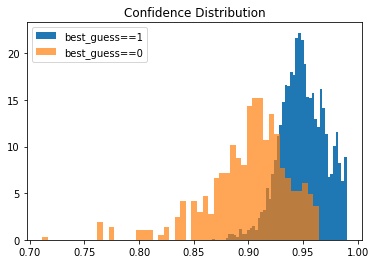

In [21]:
import matplotlib.pyplot as plt

_ = plt.hist(df[(df["selected"] == 1) & (df["env_name"].str.contains("env_1_")) & (df["t"] > 50) & (df["best_guess"] == 1)]["conf"],
             bins=50, alpha=1, density=True)
_ = plt.hist(df[(df["selected"] == 1) & (df["env_name"].str.contains("env_1_")) & (df["t"] > 50) & (df["best_guess"] == 0)]["conf"],
             bins=50, alpha=.7, density=True)
_ = plt.legend(["best_guess==1", "best_guess==0"], loc="upper left")
_ = plt.title("Confidence Distribution")